## Problem Statement - Price Category Prediction of the Medical Insurance

##### In this classification problem, we are trying to predict the range (Low, Medium, High) in which the medical insurance will lie based on the charges that are present in the dataset. 

### Data Collection
Used the data set from Kaggle, which represents the results of a survery from a medical company which aims to identify the factors responsible for medical insurance price.

### Data Pre-Processing

#### Import necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import graphviz

In [2]:
# Load the Medical Insurance dataset
datasetPath = r'Medical_insurance.csv'
df = pd.read_csv(datasetPath)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Understanding the statistics of charges column that we need to predict
df['charges'].describe()

count     2772.000000
mean     13261.369959
std      12151.768945
min       1121.873900
25%       4687.797000
50%       9333.014350
75%      16577.779500
max      63770.428010
Name: charges, dtype: float64

In [4]:
# Here, we will categorize the "charges" column into three categories based on the quantile of the data
# Low - It represents prices which lie between 0 to 33% of "charges" column
# Medium - It represents prices which lie between 33% to 66% of "charges" column
# High - It represents prices which lie between 66% to 100% of "charges" column
quantiles = df['charges'].quantile([0.33, 0.66])
print(quantiles)

# Function to categorize each value
def categorize_charges(value, quantiles):
    if value <= quantiles.iloc[0]:
        return 'Low'
    elif value <= quantiles.iloc[1]:
        return 'Medium'
    else:
        return 'High'
    
df['charges_category'] = df['charges'].apply(categorize_charges, quantiles=quantiles)

0.33     6185.3208
0.66    12592.5345
Name: charges, dtype: float64


In [5]:
df

,age,sex,bmi,children,smoker,region,charges,charges_category
0,19,female,27.900,0,yes,southwest,16884.92400,High
1,18,male,33.770,1,no,southeast,1725.55230,Low
2,28,male,33.000,3,no,southeast,4449.46200,Low
3,33,male,22.705,0,no,northwest,21984.47061,High
4,32,male,28.880,0,no,northwest,3866.85520,Low
...,...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180,Medium
2768,21,female,34.600,0,no,southwest,2020.17700,Low
2769,19,male,26.030,1,yes,northwest,16450.89470,High
2770,23,male,18.715,0,no,northwest,21595.38229,High


In [6]:
# Check for missing values
df.isnull().sum()

age                 0
sex                 0
bmi                 0
children            0
smoker              0
region              0
charges             0
charges_category    0
dtype: int64

In [7]:
#Check Duplicate Value
df.duplicated().sum()

1435

In [8]:
#Remove Duplicate Value
df = df.drop_duplicates()

#Check Duplicate Value
df.duplicated().sum()

0

#### Feature Engineering

In [9]:
# Creating a feature "weight_category" based on the Body Mass Index(BMI) value
df['weight_category'] = np.where(df['bmi'] < 18.000, 'underweight', np.where(df['bmi'] < 25.000, 'normal', np.where(df['bmi'] < 30.000, 'overweight', 'obese')))

/var/folders/g5/p0g0c4392y5f0nb8bl_8hw_h0000gn/T/ipykernel_75568/1714023708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weight_category'] = np.where(df['bmi'] < 18.000, 'underweight', np.where(df['bmi'] < 25.000, 'normal', np.where(df['bmi'] < 30.000, 'overweight', 'obese')))


In [10]:
# Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   int64  
 1   sex               1337 non-null   object 
 2   bmi               1337 non-null   float64
 3   children          1337 non-null   int64  
 4   smoker            1337 non-null   object 
 5   region            1337 non-null   object 
 6   charges           1337 non-null   float64
 7   charges_category  1337 non-null   object 
 8   weight_category   1337 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 104.5+ KB


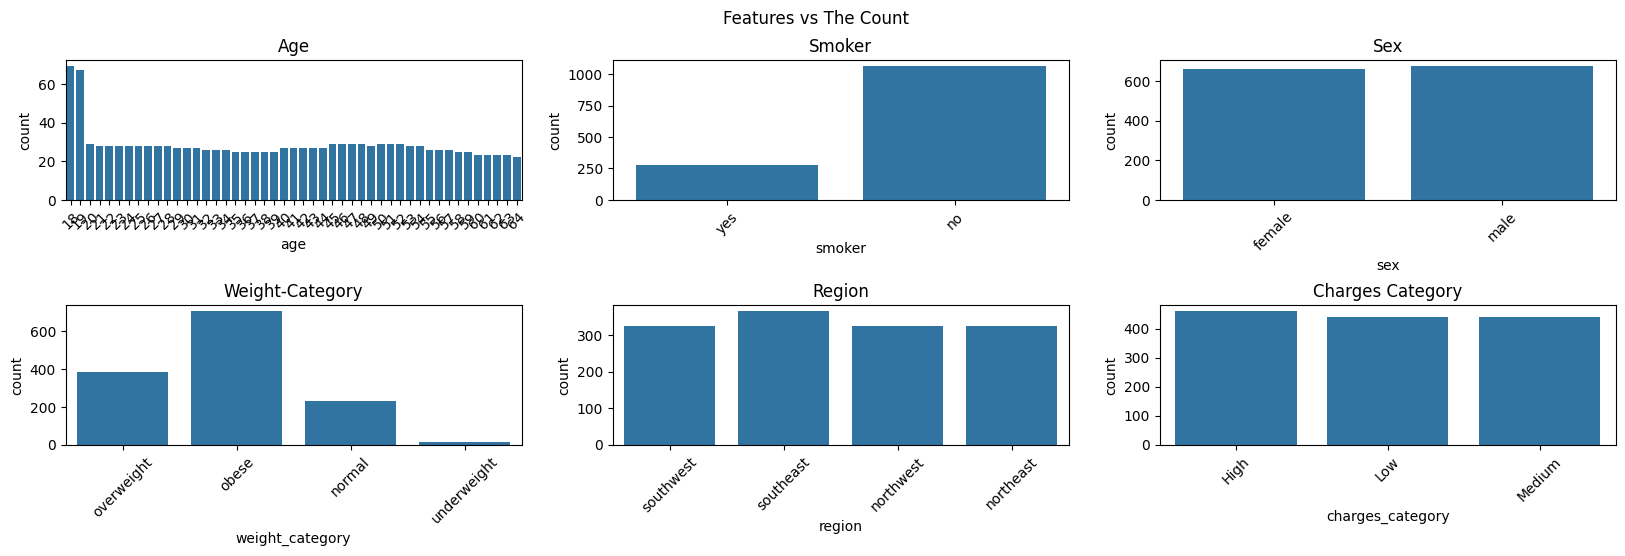

In [11]:
# Plotting the graphs for features which helps us identify the values that
# each feature has.
figr, axes = plt.subplots(2, 3, figsize=(20, 5))
figr.suptitle('Features vs The Count')

# Age
sns.countplot(ax=axes[0][0], x="age", data=df)
axes[0][0].set_title("Age")
axes[0][0].tick_params(axis='x', rotation=45)

# Smoker
sns.countplot(ax=axes[0][1], x="smoker", data=df)
axes[0][1].set_title("Smoker")
axes[0][1].tick_params(axis='x', rotation=45)

# Sex
sns.countplot(ax=axes[0][2], x="sex", data=df)
axes[0][2].set_title("Sex")
axes[0][2].tick_params(axis='x', rotation=45)

# Leave space between two rows
figr.subplots_adjust(hspace=0.75)

# Weight-Category
sns.countplot(ax=axes[1][0], x="weight_category", data=df)
axes[1][0].set_title("Weight-Category")
axes[1][0].tick_params(axis='x', rotation=45)

# Region
sns.countplot(ax=axes[1][1], x="region", data=df)
axes[1][1].set_title("Region")
axes[1][1].tick_params(axis='x', rotation=45)

# Charges Category
sns.countplot(ax=axes[1][2], x="charges_category", data=df)
axes[1][2].set_title("Charges Category")
axes[1][2].tick_params(axis='x', rotation=45)

In [12]:
#Segregating values into numerical and categorial values
categorialVals = ["sex", "smoker", "region", "weight_category", "charges_category"]
df[categorialVals].describe()

,sex,smoker,region,weight_category,charges_category
count,1337,1337,1337,1337,1337
unique,2,2,4,4,3
top,male,no,southeast,obese,High
freq,675,1063,364,706,459


In [13]:
numericalVals = ["age", "bmi", "charges", "children"]
df[numericalVals].describe()

,age,bmi,charges,children
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,13279.121487,1.095737
std,14.044333,6.100468,12110.359656,1.205571
min,18.000000,15.960000,1121.873900,0.000000
25%,27.000000,26.290000,4746.344000,0.000000
50%,39.000000,30.400000,9386.161300,1.000000
75%,51.000000,34.700000,16657.717450,2.000000
max,64.000000,53.130000,63770.428010,5.000000


#### Feature Transformation

In [14]:
dfTransformed = df.copy()

In [15]:
# Encoding the columns to make data easily available for ML algorithms
dfTransformed['smoker'] = dfTransformed['smoker'].replace({'yes' : 0, 'no' : 1})

# Encoding the charges_category fields to numerical values
dfTransformed['charges_category'] = dfTransformed['charges_category'].apply(lambda x: {'Low': 0, 'Medium': 1, 'High': 2}[x])

# Creating dummies for columns like sex, region and weight_category
sex_ori = pd.get_dummies(dfTransformed['sex'], prefix = 'sex')
region_ori = pd.get_dummies(dfTransformed['region'], prefix = 'reg')
status_ori = pd.get_dummies(dfTransformed['weight_category'], prefix = 'status')

#Concat Feature Encoding
dfTransformed = pd.concat([dfTransformed, sex_ori], axis=1)
dfTransformed = pd.concat([dfTransformed, region_ori], axis=1)
dfTransformed = pd.concat([dfTransformed, status_ori], axis=1)

In [16]:
# Remove the encoded features from the transformed dataframe
dfTransformed = dfTransformed.drop(columns = ['bmi', 'sex', 'region', 'weight_category', 'charges'])

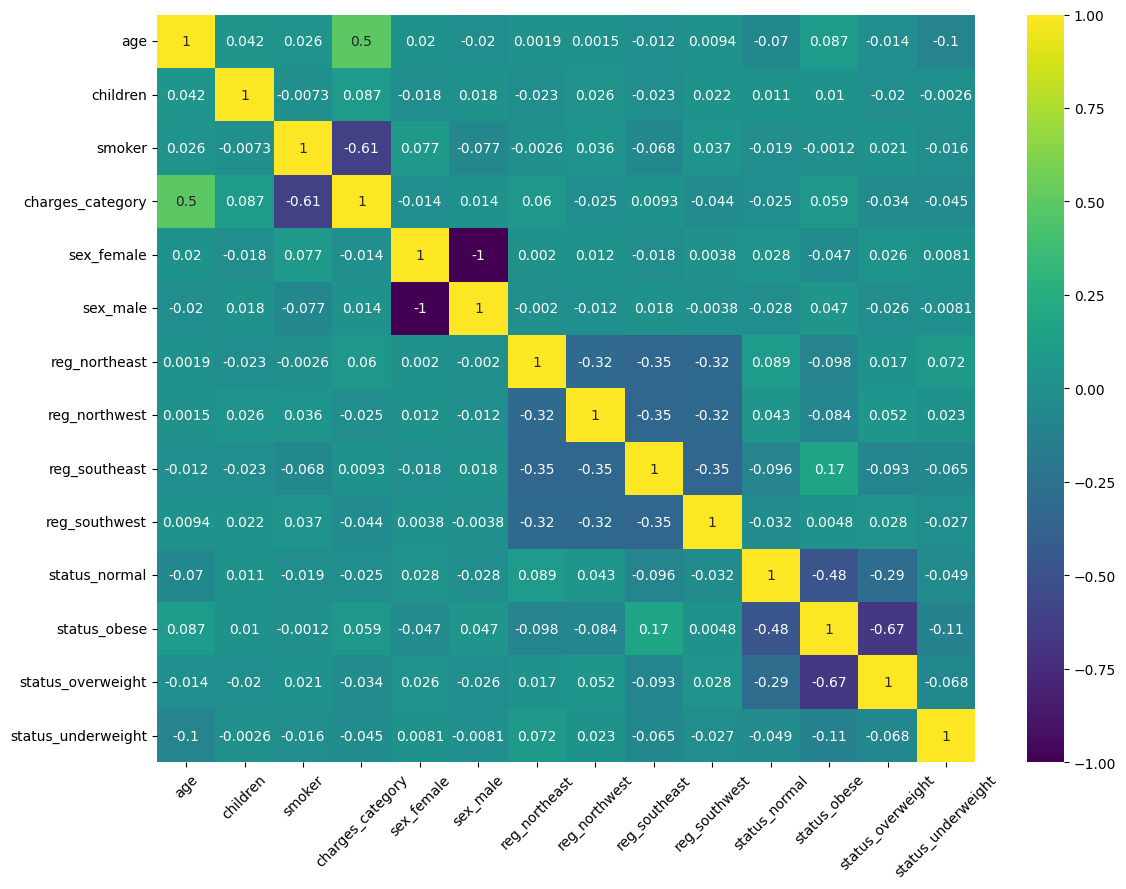

In [17]:
# Plotting correlation matrix for analysis
plt.figure(figsize=(12, 9))
sns.heatmap(dfTransformed.corr(numeric_only=True), annot=True, cmap="viridis")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
dfTransformed

,age,children,smoker,charges_category,sex_female,sex_male,reg_northeast,reg_northwest,reg_southeast,reg_southwest,status_normal,status_obese,status_overweight,status_underweight
0,19,0,0,2,True,False,False,False,False,True,False,False,True,False
1,18,1,1,0,False,True,False,False,True,False,False,True,False,False
2,28,3,1,0,False,True,False,False,True,False,False,True,False,False
3,33,0,1,2,False,True,False,True,False,False,True,False,False,False
4,32,0,1,0,False,True,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,3,1,1,False,True,False,True,False,False,False,True,False,False
1334,18,0,1,0,True,False,True,False,False,False,False,True,False,False
1335,18,0,1,0,True,False,False,False,True,False,False,True,False,False
1336,21,0,1,0,True,False,False,False,False,True,False,False,True,False


### Data Modeling

#### Helper function to evaluate performance of different models

In [19]:
classifierResults = {}
# Model Evaluation
def evaluation(modelName, model, prediction, xtrain, ytrain, xtest, ytest):
    classifierResults[modelName] = accuracy_score(ytest, prediction)
    print('R2 score : %.2f' % r2_score(ytest, prediction)) # R2 score
    print('Train Accuracy :', model.score(xtrain, ytrain)) # Train Accuracy
    print('Test Accuracy :', model.score(xtest, ytest)) # Test Accuracy
    print('Accuracy :', accuracy_score(ytest, prediction))
    print('Classification Report:')
    print(classification_report(ytest, prediction, target_names=['Low', 'Medium', 'High']))

#### Split the Data

In [20]:
# Separating Target & Features
x = dfTransformed.drop(columns = ['charges_category']) #Features
y = dfTransformed['charges_category'] #Target


# Splitting Train & Test 
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 42)

#### Perform Normalization

In [21]:
# Defining the scalers first inorder to save their state for future use
scalers = {
    'age': MinMaxScaler(),
    'children': MinMaxScaler()
}

# Fit and transform the training data
xtrain['age'] = scalers['age'].fit_transform(xtrain['age'].values.reshape(-1, 1))
xtrain['children'] = scalers['children'].fit_transform(xtrain['children'].values.reshape(-1, 1))

In [22]:
# Now, we will apply only the transformation on the test dataset
xtest['age'] = scalers['age'].transform(xtest['age'].values.reshape(-1, 1))
xtest['children'] = scalers['children'].transform(xtest['children'].values.reshape(-1, 1)) 

#### SVM (Support Vector Machine)

In [23]:
# Create SVM classifier
svm = SVC(kernel='linear')
svm.fit(xtrain, ytrain)
y_pred = svm.predict(xtest)
print(evaluation("Support Vector Machine", svm, y_pred, xtrain, ytrain, xtest, ytest))

R2 score : 0.70
Train Accuracy : 0.8437792329279701
Test Accuracy : 0.8507462686567164
Accuracy : 0.8507462686567164
Classification Report:
              precision    recall  f1-score   support

         Low       0.91      0.98      0.94        88
      Medium       0.73      0.95      0.82        86
        High       1.00      0.64      0.78        94

    accuracy                           0.85       268
   macro avg       0.88      0.86      0.85       268
weighted avg       0.88      0.85      0.85       268

None


In [24]:
# Getting top features used in the classification
weights = svm.coef_[0]
important_features =  np.abs(weights)
sorted_ind = np.argsort(important_features)[::-1]

print(xtrain.columns)

# Display the feature importance
for idx in sorted_ind:
    print(f"Feature - {xtrain.columns[idx]} has importance of {important_features[idx]}")

Index(['age', 'children', 'smoker', 'sex_female', 'sex_male', 'reg_northeast',
       'reg_northwest', 'reg_southeast', 'reg_southwest', 'status_normal',
       'status_obese', 'status_overweight', 'status_underweight'],
      dtype='object')
Feature - age has importance of 8.364204074089862
Feature - children has importance of 2.423951404318938
Feature - reg_northeast has importance of 0.364040073143876
Feature - reg_southeast has importance of 0.36393432115867697
Feature - status_underweight has importance of 0.18120216587517346
Feature - reg_southwest has importance of 0.12118070642283385
Feature - reg_northwest has importance of 0.12107495443763838
Feature - status_obese has importance of 0.12053361442551136
Feature - sex_male has importance of 0.09117131197657358
Feature - sex_female has importance of 0.09117131197655937
Feature - status_normal has importance of 0.06124230466458869
Feature - status_overweight has importance of 0.0005737532149225899
Feature - smoker has importance 

In [25]:
print("The top two features according to SVM are:- Age and Children")

The top two features according to SVM are:- Age and Children


#### Decision Tree Classifier

In [26]:
decisionTreeClassifier = DecisionTreeClassifier()
decisionTreeClassifier.fit(xtrain, ytrain)
y_pred = decisionTreeClassifier.predict(xtest)
print(evaluation("Decision Tree", decisionTreeClassifier, y_pred, xtrain, ytrain, xtest, ytest))

R2 score : 0.61
Train Accuracy : 0.9859681945743686
Test Accuracy : 0.8582089552238806
Accuracy : 0.8582089552238806
Classification Report:
              precision    recall  f1-score   support

         Low       0.91      0.90      0.90        88
      Medium       0.86      0.81      0.84        86
        High       0.81      0.86      0.84        94

    accuracy                           0.86       268
   macro avg       0.86      0.86      0.86       268
weighted avg       0.86      0.86      0.86       268

None


In [27]:
# Create a mapping for columns and feature importance
featureMapping = dict(zip(xtrain.columns,decisionTreeClassifier.feature_importances_))
print(featureMapping)

# Sort the dictionary by importance
sortByImportance = sorted(featureMapping.items(), key=lambda item: item[1], reverse=True)
sortedFeatureMapping = dict(sortByImportance)

# Printing sorted features with their values
for feature, importance in sortedFeatureMapping.items():
    print(f"Feature - {feature} has importance of {importance}")

{'age': 0.49327971184060515, 'children': 0.07369914042596537, 'smoker': 0.3213100310056795, 'sex_female': 0.008705044771698854, 'sex_male': 0.0123096417276381, 'reg_northeast': 0.0165569846285773, 'reg_northwest': 0.007722575013257987, 'reg_southeast': 0.02034010472339101, 'reg_southwest': 0.007738393187746219, 'status_normal': 0.006368703320692807, 'status_obese': 0.015199712525396338, 'status_overweight': 0.016769956829351507, 'status_underweight': 0.0}
Feature - age has importance of 0.49327971184060515
Feature - smoker has importance of 0.3213100310056795
Feature - children has importance of 0.07369914042596537
Feature - reg_southeast has importance of 0.02034010472339101
Feature - status_overweight has importance of 0.016769956829351507
Feature - reg_northeast has importance of 0.0165569846285773
Feature - status_obese has importance of 0.015199712525396338
Feature - sex_male has importance of 0.0123096417276381
Feature - sex_female has importance of 0.008705044771698854
Feature -

In [28]:
print("The top two features according to Decision Tree Classification are:- Age and Smoker")

The top two features according to Decision Tree Classification are:- Age and Smoker


#### Random Forest Classifier

In [29]:
randomForestClassifier = RandomForestClassifier(n_estimators=100, random_state=42)
randomForestClassifier.fit(xtrain, ytrain)
y_pred = randomForestClassifier.predict(xtest)
print(evaluation("Random Forest",randomForestClassifier, y_pred, xtrain, ytrain, xtest, ytest))


R2 score : 0.73
Train Accuracy : 0.9850327408793265
Test Accuracy : 0.8805970149253731
Accuracy : 0.8805970149253731
Classification Report:
              precision    recall  f1-score   support

         Low       0.90      0.92      0.91        88
      Medium       0.83      0.87      0.85        86
        High       0.91      0.85      0.88        94

    accuracy                           0.88       268
   macro avg       0.88      0.88      0.88       268
weighted avg       0.88      0.88      0.88       268

None


In [30]:
# Create a mapping for columns and feature importance
featureMapping = dict(zip(xtrain.columns,randomForestClassifier.feature_importances_))
print(featureMapping)

# Sort the dictionary by importance
sortByImportance = sorted(featureMapping.items(), key=lambda item: item[1], reverse=True)
sortedFeatureMapping = dict(sortByImportance)

# Printing sorted features with their values
for feature, importance in sortedFeatureMapping.items():
    print(f"Feature - {feature} has importance of {importance}")

{'age': 0.5717430316533552, 'children': 0.07553439748290995, 'smoker': 0.2655008678782054, 'sex_female': 0.010195843507010024, 'sex_male': 0.0101365660605129, 'reg_northeast': 0.009751472476049695, 'reg_northwest': 0.007985707911244592, 'reg_southeast': 0.009955664646756042, 'reg_southwest': 0.00813544994186872, 'status_normal': 0.009114692493040637, 'status_obese': 0.00988595493047889, 'status_overweight': 0.009748765243250187, 'status_underweight': 0.002311585775317593}
Feature - age has importance of 0.5717430316533552
Feature - smoker has importance of 0.2655008678782054
Feature - children has importance of 0.07553439748290995
Feature - sex_female has importance of 0.010195843507010024
Feature - sex_male has importance of 0.0101365660605129
Feature - reg_southeast has importance of 0.009955664646756042
Feature - status_obese has importance of 0.00988595493047889
Feature - reg_northeast has importance of 0.009751472476049695
Feature - status_overweight has importance of 0.0097487652

In [31]:
print("The top two features according to Random Forest Classification are:- Age and Smoker")

The top two features according to Random Forest Classification are:- Age and Smoker


#### Gradient Boosting Classifier

In [32]:
gradientBoostingClassifer = GradientBoostingClassifier()
gradientBoostingClassifer.fit(xtrain, ytrain)
y_pred = gradientBoostingClassifer.predict(xtest)
print(evaluation("Gradient Boosting", gradientBoostingClassifer, y_pred, xtrain, ytrain, xtest, ytest))

R2 score : 0.77
Train Accuracy : 0.9298409728718429
Test Accuracy : 0.9216417910447762
Accuracy : 0.9216417910447762
Classification Report:
              precision    recall  f1-score   support

         Low       0.90      0.97      0.93        88
      Medium       0.90      0.94      0.92        86
        High       0.96      0.86      0.91        94

    accuracy                           0.92       268
   macro avg       0.92      0.92      0.92       268
weighted avg       0.92      0.92      0.92       268

None


In [33]:
# Create a mapping for columns and feature importance
featureMapping = dict(zip(xtrain.columns,gradientBoostingClassifer.feature_importances_))
print(featureMapping)

# Sort the dictionary by importance
sortByImportance = sorted(featureMapping.items(), key=lambda item: item[1], reverse=True)
sortedFeatureMapping = dict(sortByImportance)

# Printing sorted features with their values
for feature, importance in sortedFeatureMapping.items():
    print(f"Feature - {feature} has importance of {importance}")

{'age': 0.5367933505425931, 'children': 0.051437110905484966, 'smoker': 0.39453141915162115, 'sex_female': 0.0020615948491534376, 'sex_male': 0.003358042732189854, 'reg_northeast': 0.003959977429220413, 'reg_northwest': 0.0006900233806886157, 'reg_southeast': 0.0012949601732662954, 'reg_southwest': 0.001571873186838213, 'status_normal': 0.0018391891346527004, 'status_obese': 0.0014499749857392293, 'status_overweight': 0.0008512563502669557, 'status_underweight': 0.0001612271782852138}
Feature - age has importance of 0.5367933505425931
Feature - smoker has importance of 0.39453141915162115
Feature - children has importance of 0.051437110905484966
Feature - reg_northeast has importance of 0.003959977429220413
Feature - sex_male has importance of 0.003358042732189854
Feature - sex_female has importance of 0.0020615948491534376
Feature - status_normal has importance of 0.0018391891346527004
Feature - reg_southwest has importance of 0.001571873186838213
Feature - status_obese has importance

In [34]:
print("The top two features according to Random Forest Classification are:- Age and Smoker")

The top two features according to Random Forest Classification are:- Age and Smoker


#### KNN Algorithm (K-Nearest Neigbours)

In [35]:
# Getting the euclidean distance between two points
def euclidean_distance(row1, row2):
    return np.sqrt(np.sum((row1 - row2) ** 2))

# Function for predicting the k-nn
def knn_predict(X_train, y_train, test_instance, k):
    distances = []
    for index in range(len(X_train)):
        dist = euclidean_distance(np.array(X_train[index, :]), test_instance)
        distances.append((y_train[index], dist))
    distances.sort(key=lambda x: x[1])

    neighbors = distances[:k]

    class_votes = {}
    for neighbor in neighbors:
        label = neighbor[0]
        class_votes[label] = class_votes.get(label, 0) + 1

    sorted_votes = sorted(class_votes.items(), key=lambda x: x[1], reverse=True)
    return sorted_votes[0][0]

def cross_validate_knn(X, y, k_values, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    k_scores = {}

    for k in k_values:
        fold_scores = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            y_pred = [knn_predict(X_train, y_train, instance, k) for instance in X_test]
            accuracy = np.mean(y_pred == y_test)
            fold_scores.append(accuracy)
        k_scores[k] = np.mean(fold_scores)
    return k_scores

In [36]:
# Define the values of "k"
k_values = range(1, 15) 

# Define the number of folds for cross-validation
num_folds = 10 

# Perform cross-validation
optimal_k_scores = cross_validate_knn(x.values, y.values, k_values, num_folds)

# Find the key with the highest accuracy
optimal_k = max(optimal_k_scores, key=optimal_k_scores.get)
optimal_accuracy = optimal_k_scores[optimal_k]

print("Optimal k-neighbours according to cross-validation are: ", optimal_k)
print("The accuracy of the KNN model with optimal neighbour is: ", optimal_accuracy)
classifierResults['KNN'] = optimal_accuracy

Optimal k-neighbours according to cross-validation are:  6
The accuracy of the KNN model with optimal neighbour is:  0.7845920772079452


### Hyperparameter Tuning

#### Performing Hyperparameter Tuning on Gradient Boosting

In [37]:
# Create the parameter grid with 6 Hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 'sqrt']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gradientBoostingClassifer, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(xtrain, ytrain)

# The best hyperparameters from GridSearchCV
best_parameters = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_parameters)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=3, n_estimators=100; total time=   0.6s
[CV] END learning_rate=0.01

In [38]:
y_pred = best_estimator.predict(xtest)
print("Following are the results of Gradient Boosting after running on the tuned parameters:- ")
print(evaluation("Gradient Boosting HyperParameter Tuned", best_estimator, y_pred, xtrain, ytrain, xtest, ytest))

Following are the results of Gradient Boosting after running on the tuned parameters:- 
R2 score : 0.77
Train Accuracy : 0.9298409728718429
Test Accuracy : 0.9216417910447762
Accuracy : 0.9216417910447762
Classification Report:
              precision    recall  f1-score   support

         Low       0.90      0.97      0.93        88
      Medium       0.90      0.94      0.92        86
        High       0.96      0.86      0.91        94

    accuracy                           0.92       268
   macro avg       0.92      0.92      0.92       268
weighted avg       0.92      0.92      0.92       268

None


##### From these results, we can observe that the training and testing accuracy has increased slightly in Gradient Boosting, once the best hyperparameters are applied

#### Performing Hyperparameter Tuning on Random Forest Classifier

In [39]:
# Create the parameter grid with 5 Hyperparameters for random forest classifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=randomForestClassifier, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(xtrain, ytrain)

# The best hyperparameters from GridSearchCV
best_parameters = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_parameters)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_e

In [40]:
y_pred = best_estimator.predict(xtest)
print("Following are the results of Random Forest after running on the tuned parameters:- ")
print(evaluation("Random Forest HyperParameter Tuned", best_estimator, y_pred, xtrain, ytrain, xtest, ytest))

Following are the results of Random Forest after running on the tuned parameters:- 
R2 score : 0.76
Train Accuracy : 0.9326473339569691
Test Accuracy : 0.914179104477612
Accuracy : 0.914179104477612
Classification Report:
              precision    recall  f1-score   support

         Low       0.90      0.95      0.93        88
      Medium       0.89      0.93      0.91        86
        High       0.95      0.86      0.91        94

    accuracy                           0.91       268
   macro avg       0.92      0.92      0.91       268
weighted avg       0.92      0.91      0.91       268

None


##### From these results, we can clearly observe that the accuracy has increased from 88% to 91.4% ,once the best hyperparameters are applied

### Final Results for all Classifiers are as follows

In [43]:
max_key_length = max(len(key) for key in classifierResults.keys())
max_value_length = max(len("{:.4f}".format(value)) for value in classifierResults.values())
total_width = max_key_length + max_value_length + 5 

print("Model" + " " * (max_key_length - len("Model")) + " | Accuracy")
print("-" * total_width)

# Print the rows of the table
for model, accuracy in classifierResults.items():
    padding = max_key_length - len(model)
    print(f"{model}{' ' * padding} | {accuracy:.4f}")

Model                                  | Accuracy
-------------------------------------------------
Support Vector Machine                 | 0.8507
Decision Tree                          | 0.8582
Random Forest                          | 0.8806
Gradient Boosting                      | 0.9216
KNN                                    | 0.7846
Gradient Boosting HyperParameter Tuned | 0.9216
Random Forest HyperParameter Tuned     | 0.9142
